In [1]:
# Cell 1: Run training and hyperparameter tuning, with persistent storage for trials

# -----------------------------
#        INPUT PARAMETERS
# -----------------------------
# Random seed
SEED = 18

# DataLoader settings
NUM_WORKERS = 4
PIN_MEMORY = True

# Baseline CNN settings
BATCH_SIZE_BASELINE = 16
NUM_EPOCHS_BASELINE = 5
LR_BASELINE = 0.001

# Cross-Validation (CV) settings
CV_FOLDS = 5
CV_EPOCHS = 5

# Optuna hyperparameter tuning settings
OPTUNA_TRIALS = 5

# Persistent storage URL (SQLite) for saving trials
STORAGE_URL = "sqlite:///hparam_results.db"

# Final model training settings (optional here)
NUM_EPOCHS_FINAL = 5
BATCH_SIZE_TEST = 16  # For test DataLoader

# Other constants
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
VAL_CURVES_FILENAME = "validation_curves.png"
VAL_LOSS_CURVES_FILENAME = "validation_loss_curves.png"
BASELINE_ACC_CURVE_FILENAME = "baseline_accuracy_curve.png"
BASELINE_LOSS_CURVE_FILENAME = "baseline_loss_curve.png"
RANDOM_MODEL_FILENAME = "cnn_random_search_best.pth"
TPE_MODEL_FILENAME = "cnn_tpe_search_best.pth"
# -----------------------------
#        END PARAMETERS
# -----------------------------

import random
import optuna
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from support import load_dataset
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# Set seed for reproducibility
def set_seed(seed: int = SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

print(f"Device in use: {DEVICE}")
print("Loading datasets...")
train_dataset, test_dataset = load_dataset()
print(f"Training set size: {len(train_dataset)}, Test set size: {len(test_dataset)}")

# Define CNN
class CNN(nn.Module):
    def __init__(self, num_filters: int = 16, dropout: float = 0.5):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, num_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(num_filters, num_filters * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 60, 30)
            out = self.features(dummy)
            flat_size = out.view(1, -1).shape[1]
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Training / evaluation helpers
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / len(loader.dataset)
    return epoch_loss, epoch_acc

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
    return correct / len(loader.dataset)

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            count += inputs.size(0)
    return total_loss / count

# ----------------------------------------------------------------------------------
# 1) Train baseline CNN with test evaluation and plot learning curves
# ----------------------------------------------------------------------------------
print("\n### Baseline CNN Training ###")
baseline_train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE_BASELINE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)
baseline_test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_BASELINE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)
baseline_model = CNN(num_filters=16, dropout=0.5).to(DEVICE)
criterion_baseline = nn.CrossEntropyLoss()
optimizer_baseline = optim.Adam(baseline_model.parameters(), lr=LR_BASELINE)

baseline_train_accs = []
baseline_train_losses = []
baseline_test_accs = []
baseline_test_losses = []

for epoch in range(1, NUM_EPOCHS_BASELINE + 1):
    train_loss, train_acc = train_one_epoch(
        baseline_model,
        baseline_train_loader,
        criterion_baseline,
        optimizer_baseline,
        DEVICE
    )
    test_loss = evaluate_loss(
        baseline_model,
        baseline_test_loader,
        criterion_baseline,
        DEVICE
    )
    test_acc = evaluate(
        baseline_model,
        baseline_test_loader,
        DEVICE
    )

    baseline_train_losses.append(train_loss)
    baseline_train_accs.append(train_acc)
    baseline_test_losses.append(test_loss)
    baseline_test_accs.append(test_acc)

    print(
        f"Baseline Epoch {epoch:02d}/{NUM_EPOCHS_BASELINE} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.4f}"
    )
print("Baseline training and evaluation complete.\n")

# Plot baseline learning curves
def plot_learning_curves(
    epochs,
    train_accs,
    test_accs,
    train_losses,
    test_losses,
    acc_title: str,
    loss_title: str,
    acc_filename: str,
    loss_filename: str
):
    # Accuracy plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accs, marker='o', label="Train Accuracy")
    plt.plot(epochs, test_accs, marker='s', label="Test Accuracy")
    # Highlight maxima
    if train_accs:
        best_train_idx = int(np.argmax(train_accs))
        best_train_val = max(train_accs)
        plt.scatter(epochs[best_train_idx], best_train_val, color='blue')
        plt.text(
            epochs[best_train_idx],
            best_train_val + 0.01,
            f"Max Train Acc: {best_train_val:.2f}",
            color='blue'
        )
    if test_accs:
        best_test_idx = int(np.argmax(test_accs))
        best_test_val = max(test_accs)
        plt.scatter(epochs[best_test_idx], best_test_val, color='orange')
        plt.text(
            epochs[best_test_idx],
            best_test_val + 0.01,
            f"Max Test Acc: {best_test_val:.2f}",
            color='orange'
        )
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(acc_title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(acc_filename, dpi=300)
    plt.show()

    # Loss plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, marker='o', label="Train Loss")
    plt.plot(epochs, test_losses, marker='s', label="Test Loss")
    # Highlight minima
    if train_losses:
        best_train_loss_idx = int(np.argmin(train_losses))
        best_train_loss_val = min(train_losses)
        plt.scatter(epochs[best_train_loss_idx], best_train_loss_val, color='blue')
        plt.text(
            epochs[best_train_loss_idx],
            best_train_loss_val + 0.01,
            f"Min Train Loss: {best_train_loss_val:.2f}",
            color='blue'
        )
    if test_losses:
        best_test_loss_idx = int(np.argmin(test_losses))
        best_test_loss_val = min(test_losses)
        plt.scatter(epochs[best_test_loss_idx], best_test_loss_val, color='orange')
        plt.text(
            epochs[best_test_loss_idx],
            best_test_loss_val + 0.01,
            f"Min Test Loss: {best_test_loss_val:.2f}",
            color='orange'
        )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(loss_title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(loss_filename, dpi=300)
    plt.show()

epochs_baseline = np.arange(1, NUM_EPOCHS_BASELINE + 1)
print("Plotting baseline learning curves...")
plot_learning_curves(
    epochs=epochs_baseline,
    train_accs=baseline_train_accs,
    test_accs=baseline_test_accs,
    train_losses=baseline_train_losses,
    test_losses=baseline_test_losses,
    acc_title="Baseline CNN: Train & Test Accuracy per Epoch",
    loss_title="Baseline CNN: Train & Test Loss per Epoch",
    acc_filename=BASELINE_ACC_CURVE_FILENAME,
    loss_filename=BASELINE_LOSS_CURVE_FILENAME
)

# ----------------------------------------------------------------------------------
# 3) Hyperparameter tuning with Optuna (tracking mean CV accuracy and loss)
# ----------------------------------------------------------------------------------
print("\n### Starting Hyperparameter Tuning ###")
labels_list = [int(train_dataset[i][1]) for i in range(len(train_dataset))]
all_indices = list(range(len(train_dataset)))

def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.1, 0.7)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32])
    num_filters = trial.suggest_int("num_filters", 16, 64, step=16)

    print(
        f"Trial {trial.number}: lr={lr:.2e}, dropout={dropout:.2f}, optimizer={optimizer_name}, "
        f"batch_size={batch_size}, num_filters={num_filters}"
    )

    skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=SEED)
    fold_accuracies = []
    fold_losses = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(all_indices, labels_list), start=1):
        train_sub = Subset(train_dataset, train_idx)
        val_sub   = Subset(train_dataset, val_idx)

        train_loader = DataLoader(
            train_sub,
            batch_size=batch_size,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=PIN_MEMORY
        )
        val_loader = DataLoader(
            val_sub,
            batch_size=batch_size,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=PIN_MEMORY
        )

        model = CNN(num_filters=num_filters, dropout=dropout).to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = (
            optim.Adam(model.parameters(), lr=lr)
            if optimizer_name == "Adam"
            else optim.SGD(model.parameters(), lr=lr)
        )

        for epoch in range(1, CV_EPOCHS + 1):
            train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
            if epoch % 5 == 0 or epoch == CV_EPOCHS:
                print(f"  Trial {trial.number} • Fold {fold_idx} Epoch {epoch}/{CV_EPOCHS}")

        # Compute CV loss and accuracy
        total_loss = 0.0
        correct = 0
        total = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += inputs.size(0)
        mean_loss_fold = total_loss / total
        acc_fold = correct / total

        print(
            f"  Trial {trial.number} Fold {fold_idx} results -> "
            f"Acc: {acc_fold:.4f}, Loss: {mean_loss_fold:.4f}"
        )

        fold_losses.append(mean_loss_fold)
        fold_accuracies.append(acc_fold)

    mean_cv_acc  = float(np.mean(fold_accuracies))
    mean_cv_loss = float(np.mean(fold_losses))
    trial.set_user_attr("mean_cv_loss", mean_cv_loss)
    print(
        f"Trial {trial.number} mean CV Acc: {mean_cv_acc:.4f}, "
        f"mean CV Loss: {mean_cv_loss:.4f}\n"
    )
    return mean_cv_acc

print("Starting Random Search...")
study_random = optuna.create_study(
    study_name="random_search",
    storage=STORAGE_URL,
    load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.RandomSampler()
)
study_random.optimize(objective, n_trials=OPTUNA_TRIALS)

print("Starting TPE Search...")
study_tpe = optuna.create_study(
    study_name="tpe_search",
    storage=STORAGE_URL,
    load_if_exists=True,
    direction="maximize",
    sampler=optuna.samplers.TPESampler()
)
study_tpe.optimize(objective, n_trials=OPTUNA_TRIALS)

print("Hyperparameter tuning complete.")
print(
    f"Random Search best params: {study_random.best_params}, "
    f"CV acc: {study_random.best_value:.4f}, "
    f"CV loss: {study_random.best_trial.user_attrs['mean_cv_loss']:.4f}"
)
print(
    f"TPE Search best params:    {study_tpe.best_params},    "
    f"CV acc: {study_tpe.best_value:.4f},    "
    f"CV loss: {study_tpe.best_trial.user_attrs['mean_cv_loss']:.4f}\n"
)

Device in use: cuda
Loading datasets...
Training set size: 136, Test set size: 34

### Baseline CNN Training ###
Baseline Epoch 01/5 | Train Loss: 0.7053, Train Acc: 0.4118 | Test  Loss: 0.6917, Test  Acc: 0.7059
Baseline Epoch 02/5 | Train Loss: 0.6924, Train Acc: 0.5074 | Test  Loss: 0.6899, Test  Acc: 0.5000
Baseline Epoch 03/5 | Train Loss: 0.6799, Train Acc: 0.5809 | Test  Loss: 0.6854, Test  Acc: 0.6471


KeyboardInterrupt: 

Loading studies from disk...

Random Search trial summary:
  Trial # 0 | Params={'lr': 0.004187903186122183, 'dropout': 0.3655175530218532, 'optimizer': 'SGD', 'batch_size': 16, 'num_filters': 32} | CV Acc=N/A | CV Loss=N/A
  Trial # 1 | Params={'lr': 0.00788192338071807, 'dropout': 0.41172972278612774, 'optimizer': 'SGD', 'batch_size': 16, 'num_filters': 16} | CV Acc=N/A | CV Loss=N/A
  Trial # 2 | Params={'lr': 0.002782082381107915, 'dropout': 0.6319009578217486, 'optimizer': 'SGD', 'batch_size': 16, 'num_filters': 32} | CV Acc=0.5 | CV Loss=0.6928005957729602
  Trial # 3 | Params={'lr': 0.0010764334884126115, 'dropout': 0.4864129477171596, 'optimizer': 'Adam', 'batch_size': 16, 'num_filters': 16} | CV Acc=0.6896825396825397 | CV Loss=0.6593968047666802
  Trial # 4 | Params={'lr': 3.852238266840861e-05, 'dropout': 0.20485068262740005, 'optimizer': 'Adam', 'batch_size': 32, 'num_filters': 64} | CV Acc=0.6695767195767196 | CV Loss=0.6891204237937927
  Trial # 5 | Params={'lr': 0.000113

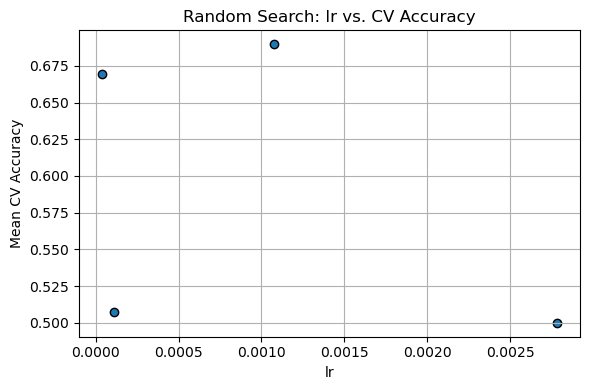

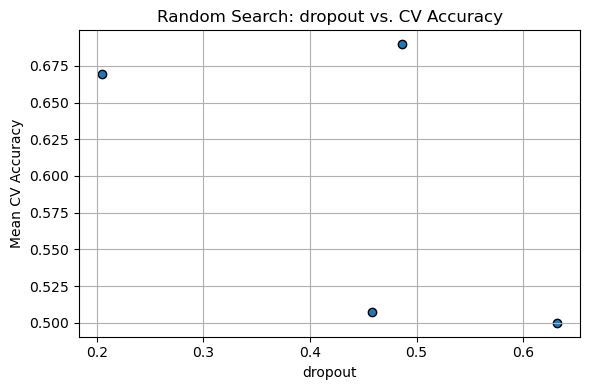

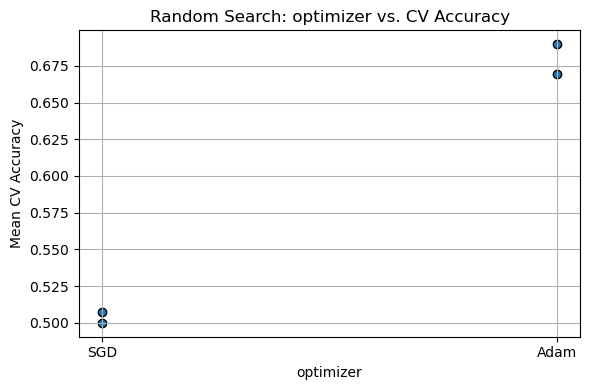

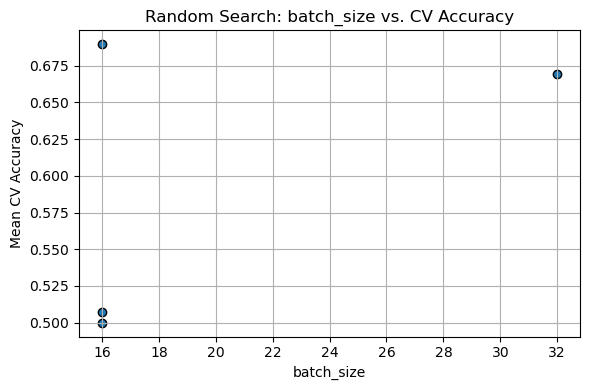

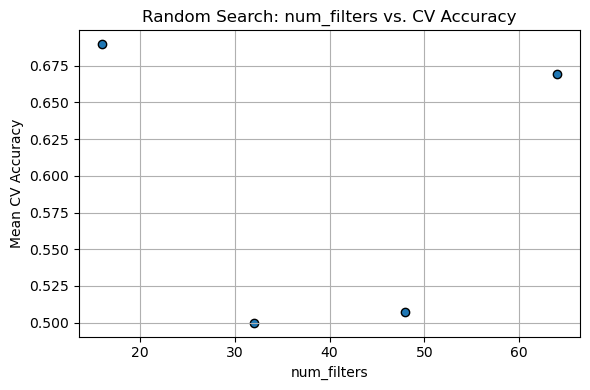

Plotting validation accuracy curves...


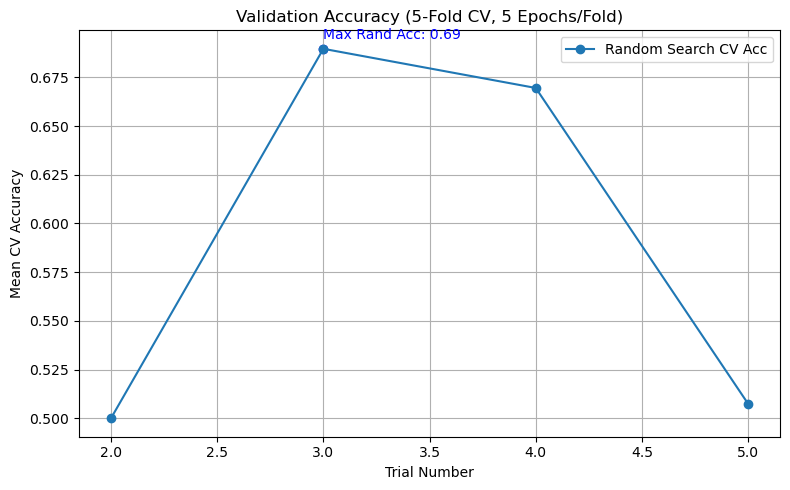

Plotting validation loss curves...


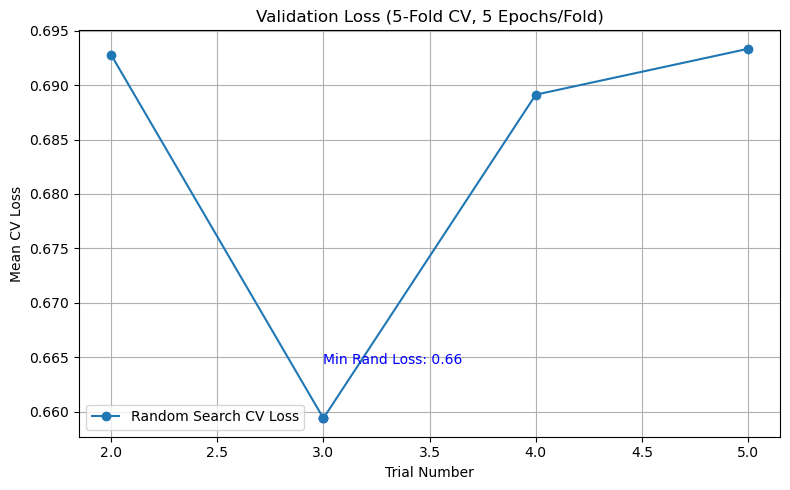


Random best-so-far trial #3 | Hyperparams: {'lr': 0.0010764334884126115, 'dropout': 0.4864129477171596, 'optimizer': 'Adam', 'batch_size': 16, 'num_filters': 16} | CV Acc: 0.6897 | CV Loss: 0.6594
Training Random-Search best-so-far model on full training set...
Epoch 01/5 | Train Loss: 0.6913, Train Acc: 0.5294 | Test  Loss: 0.6917, Test  Acc: 0.5000
Epoch 02/5 | Train Loss: 0.7036, Train Acc: 0.4632 | Test  Loss: 0.6880, Test  Acc: 0.7059
Epoch 03/5 | Train Loss: 0.6823, Train Acc: 0.5294 | Test  Loss: 0.6843, Test  Acc: 0.5000
Epoch 04/5 | Train Loss: 0.6701, Train Acc: 0.6324 | Test  Loss: 0.6714, Test  Acc: 0.5882
Epoch 05/5 | Train Loss: 0.6613, Train Acc: 0.6397 | Test  Loss: 0.6547, Test  Acc: 0.6471
Plotting learning curves for Random-Search best-so-far…


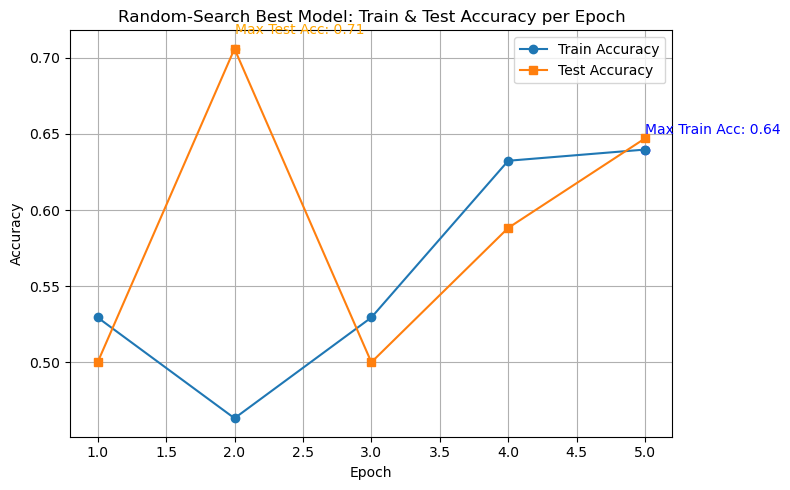

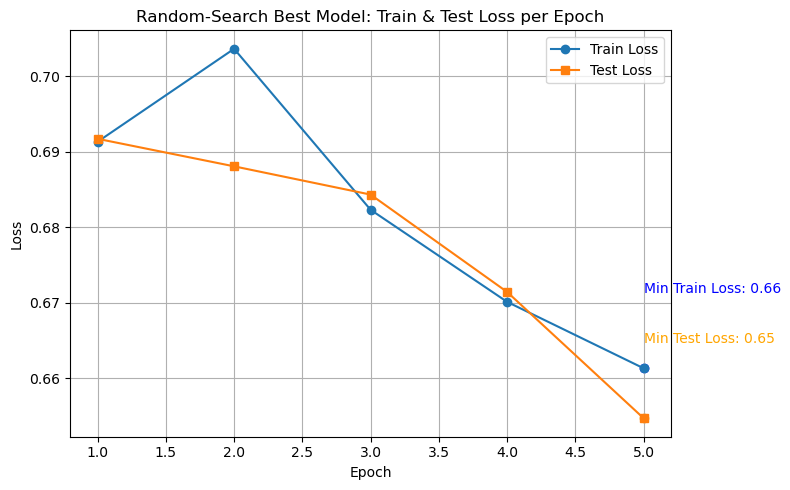

Skipping TPE-Search retrain because study not found.


In [4]:
# Cell 2: Plot validation curves & train best-so-far models on full data
# (Handles missing studies gracefully and re-imports needed names)

import optuna
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold

# -----------------------------
# Re‐define the constants from Cell 1 that Cell 2 relies on:
# -----------------------------
SEED = 18

# (These must match whatever you used in Cell 1)
NUM_WORKERS      = 4
PIN_MEMORY       = True
CV_FOLDS         = 5
CV_EPOCHS        = 5
NUM_EPOCHS_FINAL = 5
BATCH_SIZE_TEST  = 16

# Filenames for plots & model checkpoints
VAL_CURVES_FILENAME      = "validation_curves.png"
VAL_LOSS_CURVES_FILENAME = "validation_loss_curves.png"

# Make sure train_dataset, test_dataset, and CNN are already defined by running Cell 1
# If you restarted the kernel, re‐run Cell 1 first.

# -----------------------------
# 1) Re-define any helpers from Cell 1 that Cell 2 needs:
# -----------------------------

def train_full_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs: int):
    train_accs = []
    train_losses = []
    test_accs = []
    test_losses = []
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        model.train()
        running_loss = 0.0
        correct = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
        train_loss = running_loss / len(train_loader.dataset)
        train_acc  = correct / len(train_loader.dataset)

        # Evaluate on test set for both loss and accuracy
        model.eval()
        total_loss = 0.0
        correct = 0
        count = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                count += inputs.size(0)
        test_loss = total_loss / count
        test_acc  = correct / count

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(
            f"Epoch {epoch:02d}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.4f}"
        )

    return train_losses, train_accs, test_losses, test_accs

def plot_learning_curves(
    epochs,
    train_accs,
    test_accs,
    train_losses,
    test_losses,
    acc_title: str,
    loss_title: str,
    acc_filename: str,
    loss_filename: str
):
    # Accuracy plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_accs, marker='o', label="Train Accuracy")
    plt.plot(epochs, test_accs, marker='s', label="Test Accuracy")
    # Highlight maxima if available
    if train_accs:
        best_train_idx = int(np.argmax(train_accs))
        best_train_val = max(train_accs)
        plt.scatter(epochs[best_train_idx], best_train_val, color='blue')
        plt.text(
            epochs[best_train_idx],
            best_train_val + 0.01,
            f"Max Train Acc: {best_train_val:.2f}",
            color='blue'
        )
    if test_accs:
        best_test_idx = int(np.argmax(test_accs))
        best_test_val = max(test_accs)
        plt.scatter(epochs[best_test_idx], best_test_val, color='orange')
        plt.text(
            epochs[best_test_idx],
            best_test_val + 0.01,
            f"Max Test Acc: {best_test_val:.2f}",
            color='orange'
        )
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(acc_title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(acc_filename, dpi=300)
    plt.show()

    # Loss plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, marker='o', label="Train Loss")
    plt.plot(epochs, test_losses, marker='s', label="Test Loss")
    # Highlight minima if available
    if train_losses:
        best_train_loss_idx = int(np.argmin(train_losses))
        best_train_loss_val = min(train_losses)
        plt.scatter(epochs[best_train_loss_idx], best_train_loss_val, color='blue')
        plt.text(
            epochs[best_train_loss_idx],
            best_train_loss_val + 0.01,
            f"Min Train Loss: {best_train_loss_val:.2f}",
            color='blue'
        )
    if test_losses:
        best_test_loss_idx = int(np.argmin(test_losses))
        best_test_loss_val = min(test_losses)
        plt.scatter(epochs[best_test_loss_idx], best_test_loss_val, color='orange')
        plt.text(
            epochs[best_test_loss_idx],
            best_test_loss_val + 0.01,
            f"Min Test Loss: {best_test_loss_val:.2f}",
            color='orange'
        )
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(loss_title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(loss_filename, dpi=300)
    plt.show()

# -----------------------------
# 2) Reload studies from storage (if they exist), plot validation curves
# -----------------------------
print("Loading studies from disk...")

# (a) Random Search
try:
    study_random = optuna.load_study(
        study_name="random_search",
        storage="sqlite:///hparam_results.db"
    )
    rand_exists = True

    print("\nRandom Search trial summary:")
    for t in study_random.trials:
        # trial.params is a dict of hyperparameters
        params = t.params

        # t.value is the CV accuracy (None if the trial was interrupted)
        acc = t.value if t.value is not None else "N/A"

        # t.user_attrs.get("mean_cv_loss") is the CV loss (if it was set)
        loss = t.user_attrs.get("mean_cv_loss", "N/A")

        print(
            f"  Trial #{t.number:2d} | "
            f"Params={params} | "
            f"CV Acc={acc} | CV Loss={loss}"
        )

except KeyError:
    print("Warning: 'random_search' study not found. Skipping its curves.")
    study_random = None
    rand_exists = False



# (b) TPE Search
try:
    study_tpe = optuna.load_study(
        study_name="tpe_search",
        storage="sqlite:///hparam_results.db"
    )
    tpe_exists = True

    print("\nTPE Search trial summary:")
    for t in study_tpe.trials:
        params = t.params
        acc    = t.value if t.value is not None else "N/A"
        loss   = t.user_attrs.get("mean_cv_loss", "N/A")

        print(
            f"  Trial #{t.number:2d} | "
            f"Params={params} | "
            f"CV Acc={acc} | CV Loss={loss}"
        )


except KeyError:
    print("Warning: 'tpe_search' study not found. Skipping its curves.")
    study_tpe = None
    tpe_exists = False

# If neither exists, we can exit early
if not (rand_exists or tpe_exists):
    print("No studies found. Nothing to plot or retrain.")
    raise SystemExit()

if rand_exists:
    # Filter out any trials that never reported a value
    valid_rand_trials = [t for t in study_random.trials if t.value is not None]
    rand_trial_nums   = [t.number for t in valid_rand_trials]
    rand_trial_accs   = [t.value  for t in valid_rand_trials]
    # Safely fetch mean_cv_loss: if missing, use np.nan
    rand_trial_losses = [
        t.user_attrs.get("mean_cv_loss", np.nan)
        for t in valid_rand_trials
    ]
else:
    rand_trial_nums   = []
    rand_trial_accs   = []
    rand_trial_losses = []

if tpe_exists:
    valid_tpe_trials = [t for t in study_tpe.trials if t.value is not None]
    tpe_trial_nums   = [t.number for t in valid_tpe_trials]
    tpe_trial_accs   = [t.value  for t in valid_tpe_trials]
    tpe_trial_losses = [
        t.user_attrs.get("mean_cv_loss", np.nan)
        for t in valid_tpe_trials
    ]
else:
    tpe_trial_nums   = []
    tpe_trial_accs   = []
    tpe_trial_losses = []

# --- Scatter‐plots for Random Search ---
if rand_exists:
    print("\nPlotting scatter plots of Random Search hyperparameters vs. CV accuracy...")
    # Get all hyperparameter names that were sampled in Random Search:
    rand_param_names = list(study_random.best_params.keys())

    # Filter out any trials that have no .value (so we only plot completed trials)
    valid_rand_trials = [t for t in study_random.trials if t.value is not None]

    for param in rand_param_names:
        # x = list of that param’s sampled values, y = corresponding CV‐accuracy
        x_vals = [t.params[param] for t in valid_rand_trials]
        y_vals = [t.value           for t in valid_rand_trials]

        plt.figure(figsize=(6, 4))
        plt.scatter(x_vals, y_vals, marker='o', edgecolor='k')
        plt.xlabel(param)
        plt.ylabel("Mean CV Accuracy")
        plt.title(f"Random Search: {param} vs. CV Accuracy")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"scatter_random_{param}.png", dpi=300)
        plt.show()

# --- Scatter‐plots for TPE Search ---
if tpe_exists:
    print("\nPlotting scatter plots of TPE Search hyperparameters vs. CV accuracy...")
    tpe_param_names = list(study_tpe.best_params.keys())

    valid_tpe_trials = [t for t in study_tpe.trials if t.value is not None]

    for param in tpe_param_names:
        x_vals = [t.params[param] for t in valid_tpe_trials]
        y_vals = [t.value           for t in valid_tpe_trials]

        plt.figure(figsize=(6, 4))
        plt.scatter(x_vals, y_vals, marker='s', edgecolor='k')
        plt.xlabel(param)
        plt.ylabel("Mean CV Accuracy")
        plt.title(f"TPE Search: {param} vs. CV Accuracy")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"scatter_tpe_{param}.png", dpi=300)
        plt.show()



# Plot CV accuracy vs. trial (if data is available)
if rand_exists or tpe_exists:
    print("Plotting validation accuracy curves...")
    plt.figure(figsize=(8, 5))
    if rand_exists:
        plt.plot(rand_trial_nums, rand_trial_accs, marker='o', label="Random Search CV Acc")
        best_rand_idx = rand_trial_nums[np.argmax(rand_trial_accs)]
        best_rand_val = max(rand_trial_accs)
        plt.scatter(best_rand_idx, best_rand_val, color='blue')
        plt.text(best_rand_idx, best_rand_val + 0.005, f"Max Rand Acc: {best_rand_val:.2f}", color='blue')
    if tpe_exists:
        plt.plot(tpe_trial_nums,    tpe_trial_accs,    marker='s', label="TPE Search CV Acc")
        best_tpe_idx = tpe_trial_nums[np.argmax(tpe_trial_accs)]
        best_tpe_val = max(tpe_trial_accs)
        plt.scatter(best_tpe_idx, best_tpe_val, color='orange')
        plt.text(best_tpe_idx, best_tpe_val + 0.005, f"Max TPE Acc: {best_tpe_val:.2f}", color='orange')
    plt.xlabel("Trial Number")
    plt.ylabel("Mean CV Accuracy")
    plt.title(f"Validation Accuracy ({CV_FOLDS}-Fold CV, {CV_EPOCHS} Epochs/Fold)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(VAL_CURVES_FILENAME, dpi=300)
    plt.show()

# Plot CV loss vs. trial (if data is available)
if rand_exists or tpe_exists:
    print("Plotting validation loss curves...")
    plt.figure(figsize=(8, 5))
    if rand_exists:
        plt.plot(rand_trial_nums, rand_trial_losses, marker='o', label="Random Search CV Loss")
        best_rand_loss_idx = rand_trial_nums[np.nanargmin(rand_trial_losses)]
        best_rand_loss_val = min([v for v in rand_trial_losses if not np.isnan(v)])
        plt.scatter(best_rand_loss_idx, best_rand_loss_val, color='blue')
        plt.text(best_rand_loss_idx, best_rand_loss_val + 0.005, f"Min Rand Loss: {best_rand_loss_val:.2f}", color='blue')
    if tpe_exists:
        plt.plot(tpe_trial_nums, tpe_trial_losses, marker='s', label="TPE Search CV Loss")
        best_tpe_loss_idx = tpe_trial_nums[np.nanargmin(tpe_trial_losses)]
        best_tpe_loss_val = min([v for v in tpe_trial_losses if not np.isnan(v)])
        plt.scatter(best_tpe_loss_idx, best_tpe_loss_val, color='orange')
        plt.text(best_tpe_loss_idx, best_tpe_loss_val + 0.005, f"Min TPE Loss: {best_tpe_loss_val:.2f}", color='orange')
    plt.xlabel("Trial Number")
    plt.ylabel("Mean CV Loss")
    plt.title(f"Validation Loss ({CV_FOLDS}-Fold CV, {CV_EPOCHS} Epochs/Fold)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(VAL_LOSS_CURVES_FILENAME, dpi=300)
    plt.show()

# -----------------------------
# 3) Retrain best-so-far models on full training set and plot their learning curves
# -----------------------------
# Make sure Cell 1 has run so that these names exist:
#   - train_dataset, test_dataset
#   - CNN class
#   - DEVICE, NUM_EPOCHS_FINAL, BATCH_SIZE_TEST, NUM_WORKERS, PIN_MEMORY
#   - train_full_model, plot_learning_curves

criterion_final = nn.CrossEntropyLoss()

def build_model_and_optimizer(params):
    model = CNN(num_filters=params["num_filters"], dropout=params["dropout"]).to(DEVICE)
    optimizer = (optim.Adam(model.parameters(), lr=params["lr"])
                 if params["optimizer"] == "Adam"
                 else optim.SGD(model.parameters(), lr=params["lr"]))
    return model, optimizer

# 3a) Random Search best-so-far
if rand_exists:
    best_trial_random = study_random.best_trial
    best_params_random = best_trial_random.params
    best_cv_acc_random = best_trial_random.value
    best_cv_loss_random = best_trial_random.user_attrs.get("mean_cv_loss", float("nan"))
    print(
        f"\nRandom best-so-far trial #{best_trial_random.number} | "
        f"Hyperparams: {best_params_random} | "
        f"CV Acc: {best_cv_acc_random:.4f} | CV Loss: {best_cv_loss_random:.4f}"
    )


    model_rand, opt_rand = build_model_and_optimizer(best_params_random)
    train_loader_rand = DataLoader(
        train_dataset,
        batch_size=best_params_random["batch_size"],
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE_TEST,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )

    print("Training Random-Search best-so-far model on full training set...")
    rand_train_losses, rand_train_accs, rand_test_losses, rand_test_accs = train_full_model(
        model_rand,
        train_loader_rand,
        test_loader,
        criterion_final,
        opt_rand,
        DEVICE,
        NUM_EPOCHS_FINAL
    )

    epochs_final = np.arange(1, NUM_EPOCHS_FINAL + 1)
    print("Plotting learning curves for Random-Search best-so-far…")
    plot_learning_curves(
        epochs=epochs_final,
        train_accs=rand_train_accs,
        test_accs=rand_test_accs,
        train_losses=rand_train_losses,
        test_losses=rand_test_losses,
        acc_title="Random-Search Best Model: Train & Test Accuracy per Epoch",
        loss_title="Random-Search Best Model: Train & Test Loss per Epoch",
        acc_filename="best_random_learning_curve.png",
        loss_filename="best_random_loss_curve.png"
    )
else:
    print("Skipping Random-Search retrain because study not found.")

# 3b) TPE Search best-so-far
if tpe_exists:
    best_trial_tpe = study_tpe.best_trial
    best_params_tpe = best_trial_tpe.params
    best_cv_acc_tpe = best_trial_tpe.value
    best_cv_loss_tpe = best_trial_tpe.user_attrs.get("mean_cv_loss", float("nan"))
    print(
        f"\nTPE best-so-far trial #{best_trial_tpe.number} | "
        f"Hyperparams: {best_params_tpe} | "
        f"CV Acc: {best_cv_acc_tpe:.4f} | CV Loss: {best_cv_loss_tpe:.4f}"
)


    model_tpe, opt_tpe = build_model_and_optimizer(best_params_tpe)
    train_loader_tpe = DataLoader(
        train_dataset,
        batch_size=best_params_tpe["batch_size"],
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY
    )

    print("Training TPE-Search best-so-far model on full training set...")
    tpe_train_losses, tpe_train_accs, tpe_test_losses, tpe_test_accs = train_full_model(
        model_tpe,
        train_loader_tpe,
        test_loader,
        criterion_final,
        opt_tpe,
        DEVICE,
        NUM_EPOCHS_FINAL
    )

    print("Plotting learning curves for TPE-Search best-so-far…")
    plot_learning_curves(
        epochs=epochs_final,
        train_accs=tpe_train_accs,
        test_accs=tpe_test_accs,
        train_losses=tpe_train_losses,
        test_losses=tpe_test_losses,
        acc_title="TPE-Search Best Model: Train & Test Accuracy per Epoch",
        loss_title="TPE-Search Best Model: Train & Test Loss per Epoch",
        acc_filename="best_tpe_learning_curve.png",
        loss_filename="best_tpe_loss_curve.png"
    )
else:
    print("Skipping TPE-Search retrain because study not found.")
